# CENG403 - Spring 2024 - THE3

# Task 2: CNN with PyTorch
In this task, you will implement a convolutional neural network (CNN) with PyTorch.


## 2.1 Import the Modules

Let us start with importing some libraries that we will use throughout the task.

In [ ]:
# PyTorch libraries:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt # For plotting
import numpy as np              # NumPy, for working with arrays/tensors

# install and import the torchinfo library
!pip install torchinfo
from torchinfo import summary

## 2.2 Enable GPU

First, under "Edit -> Notebook Settings -> Hardware accelerator", select a GPU. With the following, we will inform PyTorch that we want to use the GPU.

In [ ]:
if torch.cuda.is_available():
  print("Cuda (GPU support) is available and enabled!")
  device = torch.device("cuda")
else:
  print("Cuda (GPU support) is not available :(")
  device = torch.device("cpu")

Cuda (GPU support) is available and enabled!


## 2.3 The Dataset

We will use torchvision.datasets to download the CIFAR10 dataset.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:12<00:00, 13625044.90it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### 2.3.1 Visualize Samples

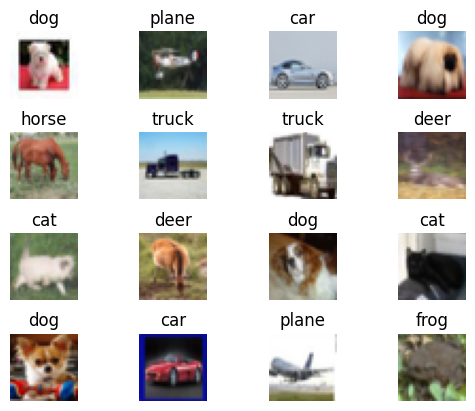

In [ ]:
dataiter = iter(trainloader)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
S = 4

for i in range(S):
  for j in range(S):
    images, labels = next(dataiter)
    X = np.transpose(images[0].numpy()/2+0.5, (1, 2, 0))
    y = labels[0]

    plt.subplot(S, S, i*S+j+1)
    plt.imshow(X)
    plt.axis('off')
    plt.title(classes[y])
    plt.subplots_adjust(hspace = 0.5)

plt.show()

## 2.4 Define and Train a Small CNN Model

Now, all the pieces are ready and we can define a model.

### 2.4.1 Model Definition

Create a three-layer CNN with the following layers:

| Layer Name | Input HxW | Filter size | Stride | Pad | # of in channels | Out HxW | # of out channels |
| ----| -----| ----| ---| ---| ----| -----|---------- |
| Conv1   | 32x32 | ? | ? | ? | 3  | 28x28 | 16 |
| Conv2   | 28x28 | ? | ? | ? | 16 | 26x26 | 32 |
| Maxpool | 26x26 | 4 | 2 | 0 | 32 | 12x12 | 32 |
| Conv3   | 12x12 | ? | ? | ? | 32 | 10x10 | 32 |

and the fully-connected layers:

| Layer Name | Input Size | Output size |
| ----| -----| ----|
| FC1 | 3200 | 1500 |
| FC2 | 1500 | 10 |

You should choose suitable values for variables marked with `?' in the table and make sure that receptive fields can be properly placed in all layers.

While creating your model, pay attention to the following aspects:
* Each Conv layer and FC layer will be followed by ReLU, except for the last one.
* You should keep all other parameters (dilation, bias, group-mode, ..) as their default values in Pytorch.

You will need to read the following pages from Pytorch regarding the layers that you will use:
* [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
* [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html?highlight=maxpool#torch.nn.MaxPool2d)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import random                   # Python's random library

class SmallCNN(nn.Module):
    def __init__(self):
        super(SmallCNN, self).__init__()

        torch.manual_seed(403)
        random.seed(403)
        np.random.seed(403)

        ###########################################################
        # @TODO: Create the convolutional and FC layers as        #
        #  described above.                                       #
        ###########################################################

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=4, stride=2, padding=0)
        self.fc1 = nn.Linear(3200, 1500)  # 32 channels, 10x10 output from Conv3
        self.fc2 = nn.Linear(1500, 10)

        self.conv_layers=nn.Sequential(self.conv1,nn.ReLU(),self.conv2, nn.ReLU(), self.maxpool, self.conv3, nn.ReLU())
        self.fc_layers=nn.Sequential(self.fc1, nn.ReLU(), self.fc2)
        ###########################################################,
        #                         END OF YOUR CODE                #
        ###########################################################

    def forward(self, x):
      ###########################################################
      # @TODO: Feedforward x through the layers. Note that x    #
      # needs to be reshaped to (batchsize, 3200) before        #
      # the FC layers.                                          #
      ###########################################################
      x=self.conv_layers(x)
      x=x.reshape((-1,3200))
      x=self.fc_layers(x)
      ###########################################################
      #                         END OF YOUR CODE                #
      ###########################################################
      return x

### 2.4.2 Trainer for the Model

Let us define our training function, which will use the cuda device for training the model.

In [ ]:
def train(model, criterion, optimizer, epochs, dataloader, verbose=True):
  """
    Define the trainer function. We can use this for training any model.
    The parameter names are self-explanatory.

    Returns: the loss history.
  """
  loss_history = []
  for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):

      # Our batch:
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      # zero the gradients as PyTorch accumulates them
      optimizer.zero_grad()

      # Obtain the scores
      outputs = model(inputs)

      # Calculate loss
      loss = criterion(outputs.to(device), labels)

      # Backpropagate
      loss.backward()

      # Update the weights
      optimizer.step()

      loss_history.append(loss.item())

    if verbose: print(f'Epoch {epoch+1} / {epochs}: avg. loss of last 5 iterations {np.sum(loss_history[:-6:-1])/5}')

  return loss_history

### 2.4.3 Create and visualize the model

In [ ]:
model = SmallCNN()

summary(model, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
SmallCNN                                 [128, 10]                 --
├─Sequential: 1-1                        [128, 32, 10, 10]         --
│    └─Conv2d: 2-1                       [128, 16, 28, 28]         1,216
│    └─ReLU: 2-2                         [128, 16, 28, 28]         --
│    └─Conv2d: 2-3                       [128, 32, 26, 26]         4,640
│    └─ReLU: 2-4                         [128, 32, 26, 26]         --
│    └─MaxPool2d: 2-5                    [128, 32, 12, 12]         --
│    └─Conv2d: 2-6                       [128, 32, 10, 10]         9,248
│    └─ReLU: 2-7                         [128, 32, 10, 10]         --
├─Sequential: 1-2                        [128, 10]                 --
│    └─Linear: 2-8                       [128, 1500]               4,801,500
│    └─ReLU: 2-9                         [128, 1500]               --
│    └─Linear: 2-10                      [128, 10]                 15

### 2.4.4 Train the Small Model

We will create an instance of our model and "define" which loss function we want to use. We will also state our choice for the optimizer here.

For more information, check the PyTorch docs: [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) and [SGD](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD).

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model = model.to(device)
epochs = 10
loss_history = train(model, criterion, optimizer, epochs, trainloader)

Epoch 1 / 10: avg. loss of last 5 iterations 2.2293365955352784
Epoch 2 / 10: avg. loss of last 5 iterations 1.9361682653427124
Epoch 3 / 10: avg. loss of last 5 iterations 1.6451322555541992
Epoch 4 / 10: avg. loss of last 5 iterations 1.5950881242752075
Epoch 5 / 10: avg. loss of last 5 iterations 1.5264392614364624
Epoch 6 / 10: avg. loss of last 5 iterations 1.4825613975524903
Epoch 7 / 10: avg. loss of last 5 iterations 1.3964977502822875
Epoch 8 / 10: avg. loss of last 5 iterations 1.331780242919922
Epoch 9 / 10: avg. loss of last 5 iterations 1.2448114156723022
Epoch 10 / 10: avg. loss of last 5 iterations 1.2438417673110962


### 2.4.5 The Loss Curve

Let us visualize the loss curve.

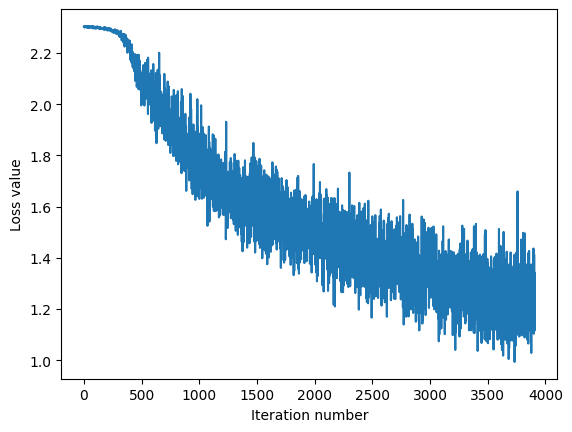

In [ ]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### 2.4.6 Quantitative Analysis

We can analyze the accuracy of the predictions as follows. You should see around 54\% accuracies. We can finetune the hyperparameters to obtain better results. But we will skip that and go for a bigger model.

*Disclaimer: This code piece is taken from PyTorch examples.*

In [ ]:
correct = 0
total = 0
model = model.to("cpu")
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


## 2.5 Your CNN

Now, create your own CNN. It should have at least 5 convolutional layers. Other than that, there is no restriction on what you can use in your CNN or how you can structure it.


### 2.5.1 Model Definition

In this section, I have utilized 5 convolutional layers, each followed by a ReLU activation function as it introduces non-linearity into the model, enabling it to learn more complex patterns. Size of the filters are chosen as 3x3, which is a common choice to capture local features while maintaining computational efficiency. The padding is set to 0 for every layer to reduce the size of the feature maps after each convolution. A stride of 1 is used for detailed feature extraction without skipping any part of the input.
 Max pooling is applied once to further reduce the spatial dimensions. Finally, two fully connected layers are used at the end that takes the flattened output of the convolutional layers and perform the final classification.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class YourCNN(nn.Module):
    def __init__(self):
        super(YourCNN, self).__init__()
        torch.manual_seed(403)
        random.seed(403)
        np.random.seed(403)
        ###########################################################
        # @TODO: Create your layers here.                         #
        ###########################################################
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(3200, 1500)  # 32 channels, 10x10 output from Conv3
        self.fc2 = nn.Linear(1500, 10)

        self.conv_layers=nn.Sequential(self.conv1, nn.ReLU(),self.conv2, nn.ReLU(), self.maxpool, self.conv3, nn.ReLU(), self.conv4, nn.ReLU(), self.conv5, nn.ReLU())
        self.fc_layers=nn.Sequential(self.fc1, nn.ReLU(), self.fc2)
        ###########################################################
        #                         END OF YOUR CODE                #
        ###########################################################

    def forward(self, x):
      ###########################################################
      # @TODO: Feedforward x through the layers.                #
      ###########################################################
        x=self.conv_layers(x)
        #print(x.shape)
        x=x.reshape((-1,3200))
        x=self.fc_layers(x)
      ###########################################################
      #                         END OF YOUR CODE                #
      ###########################################################
        return x

### 2.5.2 Create and visuale your model

In [ ]:
model = YourCNN()

summary(model, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
YourCNN                                  [128, 10]                 --
├─Sequential: 1-1                        [128, 32, 10, 10]         --
│    └─Conv2d: 2-1                       [128, 16, 30, 30]         448
│    └─ReLU: 2-2                         [128, 16, 30, 30]         --
│    └─Conv2d: 2-3                       [128, 16, 28, 28]         2,320
│    └─ReLU: 2-4                         [128, 16, 28, 28]         --
│    └─MaxPool2d: 2-5                    [128, 16, 14, 14]         --
│    └─Conv2d: 2-6                       [128, 32, 12, 12]         4,640
│    └─ReLU: 2-7                         [128, 32, 12, 12]         --
│    └─Conv2d: 2-8                       [128, 32, 10, 10]         9,248
│    └─ReLU: 2-9                         [128, 32, 10, 10]         --
│    └─Conv2d: 2-10                      [128, 32, 10, 10]         9,248
│    └─ReLU: 2-11                        [128, 32, 10, 10]         --
├─

### 2.5.3 Train the Model

For this part, I have increased the number of epochs that we are training the model for, as with 5 convolutional layers, the capacity of the model has increased. Hence, there are more parameters to optimize and learn and it requires more iterations through the dataset to minimize the loss.

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model = model.to(device)
epochs = 24
loss_history = train(model, criterion, optimizer, epochs, trainloader)

Epoch 1 / 24: avg. loss of last 5 iterations 2.30138840675354
Epoch 2 / 24: avg. loss of last 5 iterations 2.298103380203247
Epoch 3 / 24: avg. loss of last 5 iterations 2.2477416038513183
Epoch 4 / 24: avg. loss of last 5 iterations 1.9517135620117188
Epoch 5 / 24: avg. loss of last 5 iterations 1.7188316345214845
Epoch 6 / 24: avg. loss of last 5 iterations 1.7073856115341186
Epoch 7 / 24: avg. loss of last 5 iterations 1.6648239612579345
Epoch 8 / 24: avg. loss of last 5 iterations 1.6263933897018432
Epoch 9 / 24: avg. loss of last 5 iterations 1.5260056734085083
Epoch 10 / 24: avg. loss of last 5 iterations 1.4723898410797118
Epoch 11 / 24: avg. loss of last 5 iterations 1.4449926376342774
Epoch 12 / 24: avg. loss of last 5 iterations 1.5178021669387818
Epoch 13 / 24: avg. loss of last 5 iterations 1.415921401977539
Epoch 14 / 24: avg. loss of last 5 iterations 1.3946625471115113
Epoch 15 / 24: avg. loss of last 5 iterations 1.2979322671890259
Epoch 16 / 24: avg. loss of last 5 ite

### 2.5.4 Loss Curve

Let us visualize the loss curve.

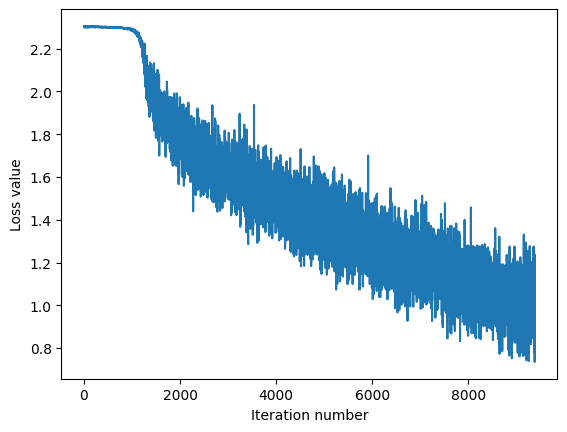

In [ ]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### 2.5.5 Quantitative Analysis

Analyze your model quantitatively.

*Disclaimer: This code piece is taken from PyTorch examples.*

In [ ]:
correct = 0
total = 0
model = model.to("cpu")
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 61 %
